#Connect to google drive and load model. Install dependencies.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
%cd /content/gdrive/MyDrive/Face_recognition

In [3]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/keras-facenet/model/facenet_keras.h5', compile=False)
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [ ]:
!pip install mtcnn

In [5]:
import os
import numpy as np
import cv2

from os import listdir
from PIL import Image
from numpy import asarray, savez_compressed, expand_dims, load
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from keras.models import load_model
from random import choice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot 
from sklearn.metrics import accuracy_score

from get_embedding import get_embedding
from face_to_embedings import face_to_embedings
from augment_selfie import augment_selfie
from make_smaller import make_smaller
from merge_image import merge_image
from extract_face import extract_face
from augmentation import rewrite_to_augmented
from load_dataset import load_dataset

get_embedding
face_to_embedings
load_dataset
extract_face

<function extract_face.extract_face>

Before we start you need to know what structure of your custom dataset need to be. Example:

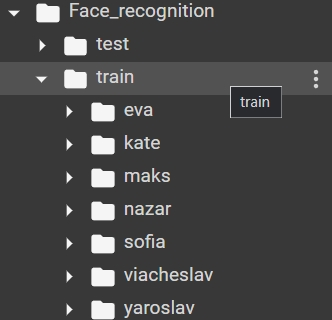

#Detect faces and do augmentation

['eva.jpg', 'eva_1.jpg', 'eva_5.jpg', 'eva_6.jpg', 'eva_4.jpg', 'eva_3.jpg']
/content/gdrive/MyDrive/Face_recognition/train/eva/eva.jpg
1 (160, 160, 3)
/content/gdrive/MyDrive/Face_recognition/train/eva/eva_1.jpg
2 (160, 160, 3)
/content/gdrive/MyDrive/Face_recognition/train/eva/eva_5.jpg
3 (160, 160, 3)
/content/gdrive/MyDrive/Face_recognition/train/eva/eva_6.jpg
4 (160, 160, 3)
/content/gdrive/MyDrive/Face_recognition/train/eva/eva_4.jpg
5 (160, 160, 3)
/content/gdrive/MyDrive/Face_recognition/train/eva/eva_3.jpg
6 (160, 160, 3)


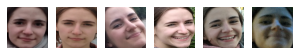

In [11]:
folder = '/content/gdrive/MyDrive/Face_recognition/train/eva'
i = 1
# enumerate files
print(listdir(folder))
for filename in listdir(folder):
    path = os.path.join(folder, filename)
    face = extract_face(path)
    print(path)
    if face is None:
      print(f'I can`t find a person in {filename}!\nI will try to use augmentation.\n')
      back = cv2.imread('backg.jpg')
      rewrite_to_augmented(path, back)
      continue
    print(i, face.shape)
    # plot
    pyplot.subplot(4, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [ ]:
%cd /content/gdrive/MyDrive/Face_recognition/

If you see "I will try to use augmentation." to use the augmented images you need to rerun the cells above.

#Make embedings

In [ ]:
train_X, train_Y = load_dataset('train/')
print(train_X.shape, train_Y.shape)
test_X, test_Y = load_dataset('test/')
savez_compressed('face_train_dataset.npz', train_X, train_Y)# save arrays to one file in compressed format
savez_compressed('face_test_dataset.npz', test_X, test_Y)

>loaded 3 examples for class: yaroslav
>loaded 2 examples for class: viacheslav
>loaded 5 examples for class: sofia
>loaded 6 examples for class: eva
>loaded 2 examples for class: nazar
>loaded 3 examples for class: maks
>loaded 4 examples for class: kate
(25, 160, 160, 3) (25,)
>loaded 1 examples for class: viacheslav
>loaded 1 examples for class: sofia
>loaded 1 examples for class: nazar
>loaded 1 examples for class: maks
>loaded 1 examples for class: eva
>loaded 1 examples for class: kate


In [ ]:
# calculate a face embedding for each face in the dataset using facenet

train = load('face_train_dataset.npz')
test = load('face_test_dataset.npz')
train_X, train_Y, test_X, test_Y = train['arr_0'], train['arr_1'], test['arr_0'], test['arr_1']
load_model('/content/gdrive/MyDrive/keras-facenet/model/facenet_keras.h5')
newTrainX = face_to_embedings(train_X, model)
newTestX = face_to_embedings(test_X, model)
savez_compressed('face_train_embeddings.npz', newTrainX, train_Y)
savez_compressed('face_test_embeddings.npz',  newTestX, test_Y)

In [ ]:
print('Loaded: ', train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
print('Loaded Model')
print(newTrainX.shape)
print(newTestX.shape)

Loaded:  (25, 160, 160, 3) (25,) (6, 160, 160, 3) (6,)
Loaded Model
(25, 128)
(6, 128)


#Perform Face Classification

In [ ]:
train = load('face_train_embeddings.npz')
test = load('face_test_embeddings.npz')
train_X, train_Y, test_X, test_Y = train['arr_0'], train['arr_1'], test['arr_0'], test['arr_1']
print(f'Dataset: train={train_X.shape[0]}, test={test_X.shape[0]}')

# normalize input vectors
in_encoder = Normalizer(norm='l2')
train_X = in_encoder.transform(train_X)
test_X = in_encoder.transform(test_X)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(train_Y)
train_Y = out_encoder.transform(train_Y)
test_Y = out_encoder.transform(test_Y)
model = SVC(kernel='linear', probability=True)
model.fit(train_X, train_Y)
yhat_train = model.predict(train_X)
yhat_test = model.predict(test_X)
score_train = accuracy_score(train_Y, yhat_train)
score_test = accuracy_score(test_Y, yhat_test)

print(f'Accuracy: train={score_train * 100:.3f}, test={score_test * 100:.3f}')

Dataset: train=25, test=6
Accuracy: train=100.000, test=100.000


Predicted: eva 60.786
Expected: eva


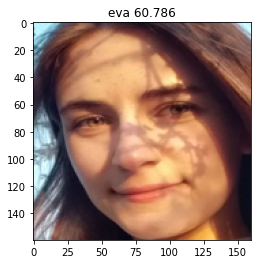

In [20]:
test = load('face_test_dataset.npz')
testX_faces = test['arr_0']
train = load('face_train_embeddings.npz')
test = load('face_test_embeddings.npz')
train_X, train_Y, test_X, test_Y = train['arr_0'], train['arr_1'], test['arr_0'], test['arr_1']
in_encoder = Normalizer(norm='l2')
train_X = in_encoder.transform(train_X)
test_X = in_encoder.transform(test_X)
out_encoder = LabelEncoder()
out_encoder.fit(train_Y)
train_Y = out_encoder.transform(train_Y)
test_Y = out_encoder.transform(test_Y)
model = SVC(kernel='linear', probability=True)
model.fit(train_X, train_Y)

selection = choice([i for i in range(test_X.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = test_X[selection]
random_face_class = test_Y[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print(f'Predicted: {predict_names[0]} {class_probability:.3f}')
print(f'Expected: {random_face_name[0]}' )
pyplot.imshow(random_face_pixels)
title = f'{predict_names[0]} {class_probability:.3f}'
pyplot.title(title)
pyplot.show()